In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
# 
def load_datasets(data_path):
    x_test = []
    y_test = []
    x_train = []
    y_train = []
    for i in os.listdir(data_path):
        for j in os.listdir(f'{data_path}/{i}'):
            for k in os.listdir(f'{data_path}/{i}/{j}'):
                if i == 'train':
                    x_train.append(f'{data_path}/{i}/{j}/{k}')
                    y_train.append(j)
                else:
                    x_test.append(f'{data_path}/{i}/{j}/{k}')
                    y_test.append(j)
    
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test) 

x_train, y_train, x_test, y_test = load_datasets('mangga_datasets_150x150')

In [5]:
# membuat label unik
def create_unique_label(label):
    return np.unique(label)

unique_label = create_unique_label(y_train)

unique_label

array(['busuk', 'matang', 'mentah'], dtype='<U6')

In [6]:
def process_label(label):
    label = [i == unique_label for i in label]
    return np.array(label).astype(int)

y_train = process_label(y_train)
y_test = process_label(y_test)

y_train[0], y_test[0]

(array([1, 0, 0]), array([1, 0, 0]))

In [7]:
def process_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

In [8]:
# pada tahap ini bertujuan untuk menyesuaikan label dengan gambar
def pair_data(image, label):
    return process_image(image), label

In [9]:
def batch_data(image, label=None, for_valid=False, for_test=False):
    if for_test:
        data = tf.data.Dataset.from_tensor_slices((image))
        data = data.map(process_image)
        batch = data.batch(20)
        return batch
    elif for_valid:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(image), tf.constant(label)))
        data = data.map(pair_data)
        batch = data.batch(20)
        return batch
    else:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(image), tf.constant(label)))
        data = data.shuffle(buffer_size=len(image))
        data = data.map(pair_data)
        batch = data.batch(20)
        return batch

train_batch = batch_data(x_train, y_train)
test_batch = batch_data(x_test, y_test, for_valid=True)

In [11]:
train_batch, test_batch

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.int32, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.int32, name=None))>)

In [10]:
def plot_history(file_name, histories):
        plt.plot(histories.history['categorical_accuracy'], label='acc')
        plt.plot(histories.history['val_categorical_accuracy'], label='val_acc')
        plt.plot(histories.history['loss'], label='loss')
        plt.plot(histories.history['val_loss'], label='val_loss')
        plt.legend()
        plt.title('Training History')
        plt.xlabel('epoch')
        plt.ylabel('value')
        plt.tight_layout()
        plt.grid(True)
        if not os.path.exists('output/plot'):
            os.makedirs('output/plot', exist_ok=True)
            plt.savefig(f'output/plot/{file_name}')
        plt.show()

In [11]:
x_train, y_train, x_test, y_test = load_datasets(data_path='mangga_data')

In [30]:
keras = tf.keras

model = keras.Sequential([
    keras.layers.Conv2D(input_shape=(150, 150, 3), filters=32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(),

    keras.layers.Flatten(),
    
    keras.layers.Dense(128),
    keras.layers.Activation(activation=keras.activations.relu),

    keras.layers.Dense(3),
    keras.layers.Activation(keras.activations.softmax)
])
model._name='deteksi_mangga'
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=keras.metrics.categorical_accuracy)

In [31]:
# create function plot_model manually
def plot_model(model):
    return keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

plot_model(model=model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [32]:
model.summary()

Model: "deteksi_mangga"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 17, 17, 128)   

In [33]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_batch, validation_data=test_batch, validation_freq=1, epochs=10, callbacks=[early_stopping], verbose=1)

Epoch 1/10


13/13 [==============================] - 16s 1s/step - loss: 0.5999 - categorical_accuracy: 0.6905 - val_loss: 0.2498 - val_categorical_accuracy: 0.8571
Epoch 2/10
13/13 [==============================] - 13s 1s/step - loss: 0.0529 - categorical_accuracy: 0.9841 - val_loss: 0.7474 - val_categorical_accuracy: 0.7460
Epoch 3/10
13/13 [==============================] - 17s 1s/step - loss: 0.1449 - categorical_accuracy: 0.9484 - val_loss: 0.0937 - val_categorical_accuracy: 0.9524
Epoch 4/10
13/13 [==============================] - 18s 1s/step - loss: 0.0593 - categorical_accuracy: 0.9802 - val_loss: 0.0923 - val_categorical_accuracy: 0.9524
Epoch 5/10
13/13 [==============================] - 15s 1s/step - loss: 0.0120 - categorical_accuracy: 0.9960 - val_loss: 0.1463 - val_categorical_accuracy: 0.9524
Epoch 6/10
13/13 [==============================] - 15s 1s/step - loss: 0.0231 - categorical_accuracy: 0.9881 - val_loss: 0.1584 - val_categorical_accuracy: 0.9365
Epoch 7/10
13/13 [=========

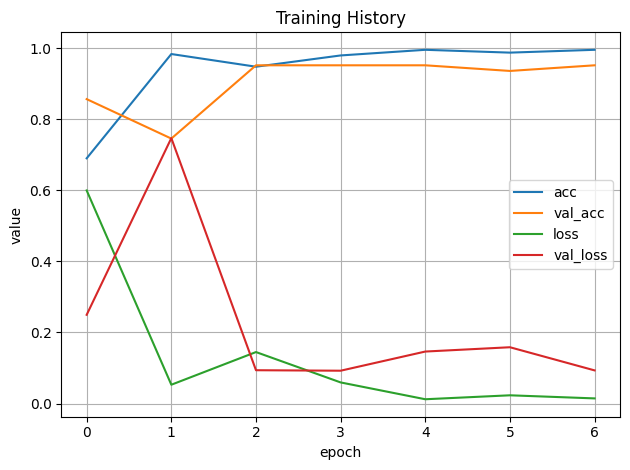

In [34]:
plot_history('model_rms_150x150.png', history)

In [35]:
model.evaluate(train_batch)

13/13 [==============================] - 4s 291ms/step - loss: 0.0027 - categorical_accuracy: 1.0000


[0.002738809213042259, 1.0]

In [2]:
def predict(models, unseen_image=[]):
    test_data = batch_data(unseen_image, for_test=True)
    prediction = models.predict(test_data)

    for image, pred in zip(unseen_image, prediction):
        fig, axes = plt.subplots(nrows=1, ncols=2)
        axes[0].imshow(process_image(image))
        axes[0].axis(False)
        axes[0].set_title('Actual Image')

        axes[1].bar([0, 1, 2], pred)
        axes[1].set_xticks([0, 1, 2])
        axes[1].set_xticklabels(unique_label)
        axes[1].set_title('Prediction')
        plt.show()

1/1 [==============================] - 0s 347ms/step


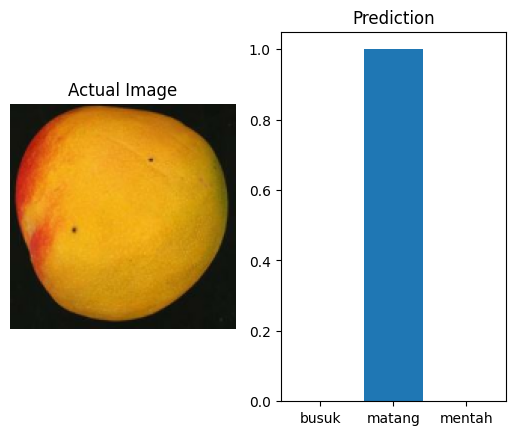

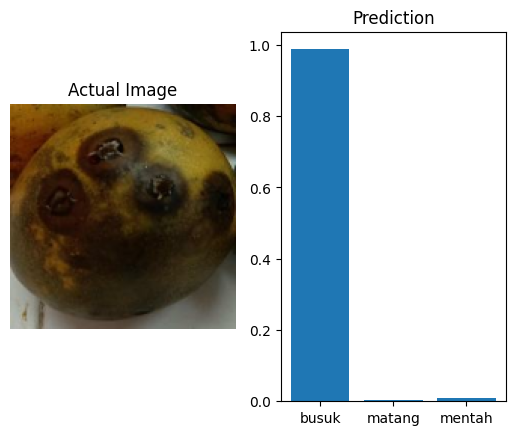

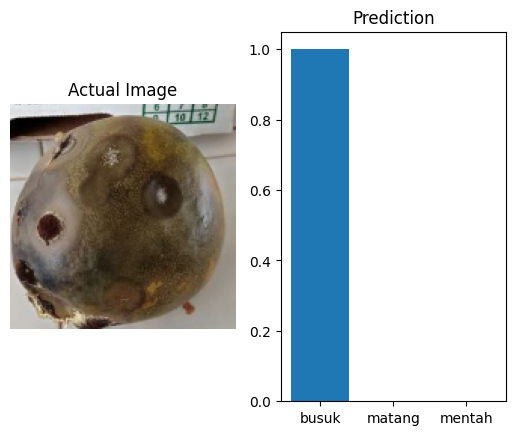

In [37]:
predict(model, list(map(lambda x: f'tes/{x}', os.listdir('tes/'))))

1/1 [==============================] - 1s 759ms/step


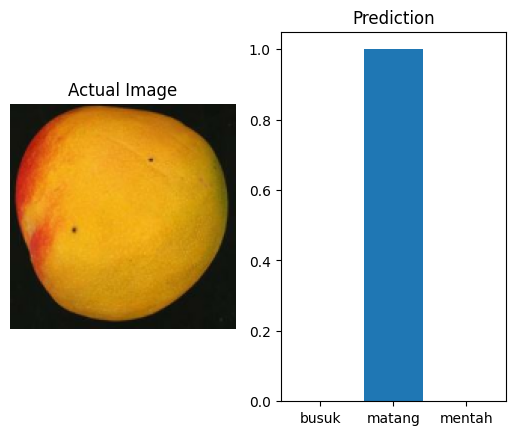

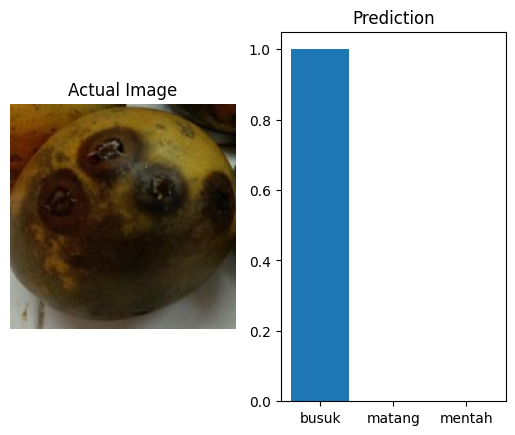

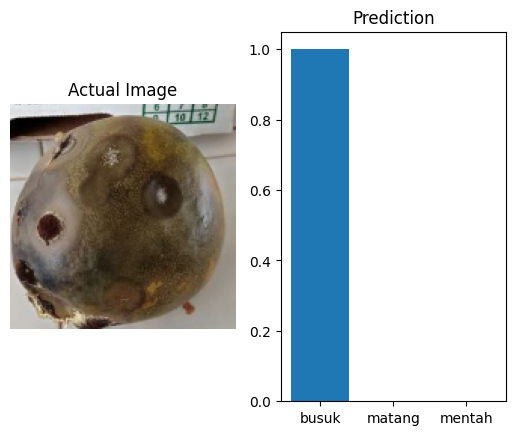

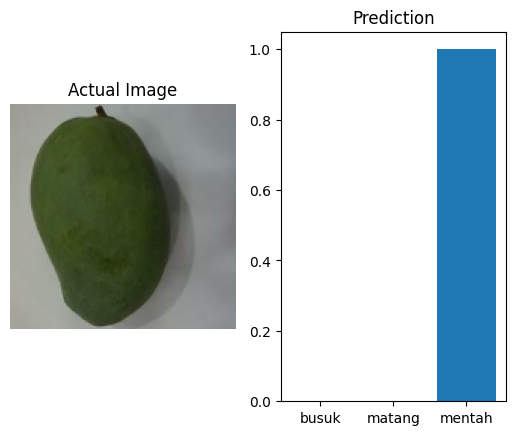

In [12]:
# load model
model = tf.keras.models.load_model('model_mangga_1.h5')

predict(model, list(map(lambda x: f'tes/{x}', os.listdir('tes/'))))